<a href="https://colab.research.google.com/github/thdhyan/5527-Project/blob/main/CSCI5527GithubFeatureExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing CLIP for later:

In [ ]:
!pip install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t0n2j449
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t0n2j449
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
import torch
import os
from google.colab import drive
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.patches as patches
import cv2
import clip
import json

In [ ]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Construct the path to the 'images' folder inside 'My Drive'
imgs_path = os.path.join('/content/drive/My Drive/CSCIProject/New Files', 'images')
annotations_path = os.path.join('/content/drive/My Drive/CSCIProject/New Files', 'annotations')
depth_imgs_path = os.path.join('/content/drive/My Drive/CSCIProject/New Files', 'depth')
# List all files in the folder and filter for common image extensions
valid_extensions = ('.png', '.jpg', '.jpeg', '.gif')
images = [f for f in os.listdir(imgs_path) if f.lower().endswith(valid_extensions)]

# List all annotation files (assuming they are JSON files)
annotation_files = [f for f in os.listdir(annotations_path) if f.lower().endswith('.json')]

# Create a set of base filenames from the annotation files (without extension)
annotation_basenames = {os.path.splitext(f)[0] for f in annotation_files}

# Filter images to only those that have a corresponding annotation file
annotated_images = [img for img in images if os.path.splitext(img)[0] in annotation_basenames]

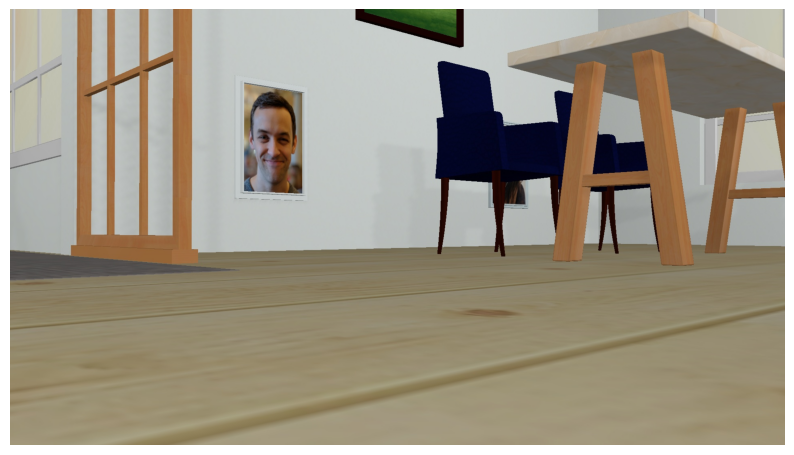

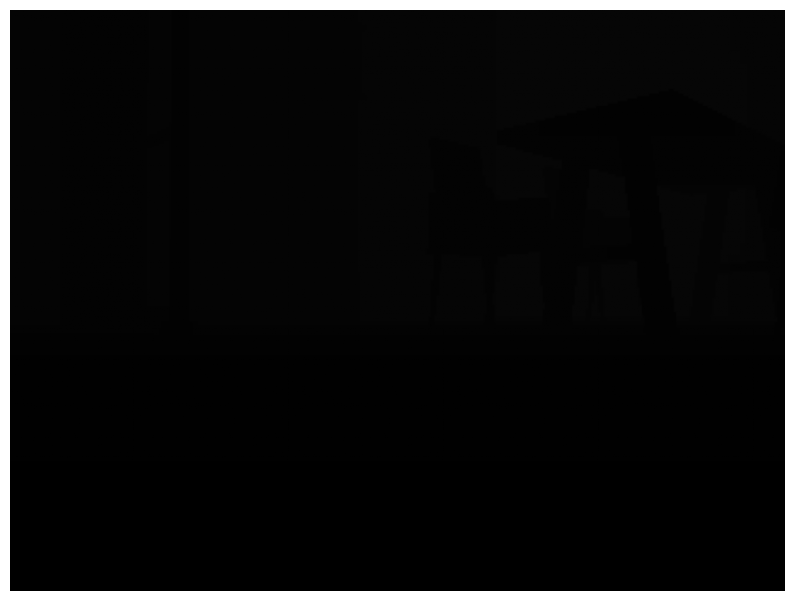

In [ ]:
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
chosen_image = random.choice(annotated_images)
image_path = os.path.join(imgs_path,chosen_image)
depth_image_path = os.path.join(depth_imgs_path, chosen_image)

image = Image.open(image_path).convert("RGB")  # load

# replace .jpg → .png for the depth image
stem, _       = Path(chosen_image).stem, Path(chosen_image).suffix
depth_png     = stem + ".png"
depth_image_path = os.path.join(depth_imgs_path, depth_png)
depth_image = Image.open(depth_image_path).convert("L")  # load

plt.figure(figsize=(10, 8))
# Use any colormap you prefer; 'viridis', 'jet', or 'plasma' are common for depth maps
plt.imshow(image)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(depth_image, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()

Attempting with bounding boxes:

In [ ]:
import json
base_name = os.path.splitext(chosen_image)[0]
json_filename = base_name + '.json'
json_path = os.path.join(annotations_path, json_filename)

# Verify that the JSON file exists, then open and load it.
if not os.path.exists(json_path):
    raise FileNotFoundError(f"JSON annotation file {json_filename} not found in {annotations_path}.")

with open(json_path, 'r') as f:
    annotation_data = json.load(f)

print("Loaded JSON annotations:")
print(annotation_data)

Loaded JSON annotations:
{'timestamp': 1744805423.7634535, 'detections': [], 'image_path': '/ros2_ws/data_collection/20250416_114303/images/20250416_121023_763.jpg', 'depth_path': '/ros2_ws/data_collection/20250416_114303/depth/20250416_121023_763.png', 'robot_pose': {'translation': {'x': 9.633108494029315, 'y': -2.045388501225874, 'z': 0.01}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.4757831546192296, 'w': 0.879562612768741}}}


(1920, 1080)
(320, 240)
0.16666666666666666
0.2222222222222222


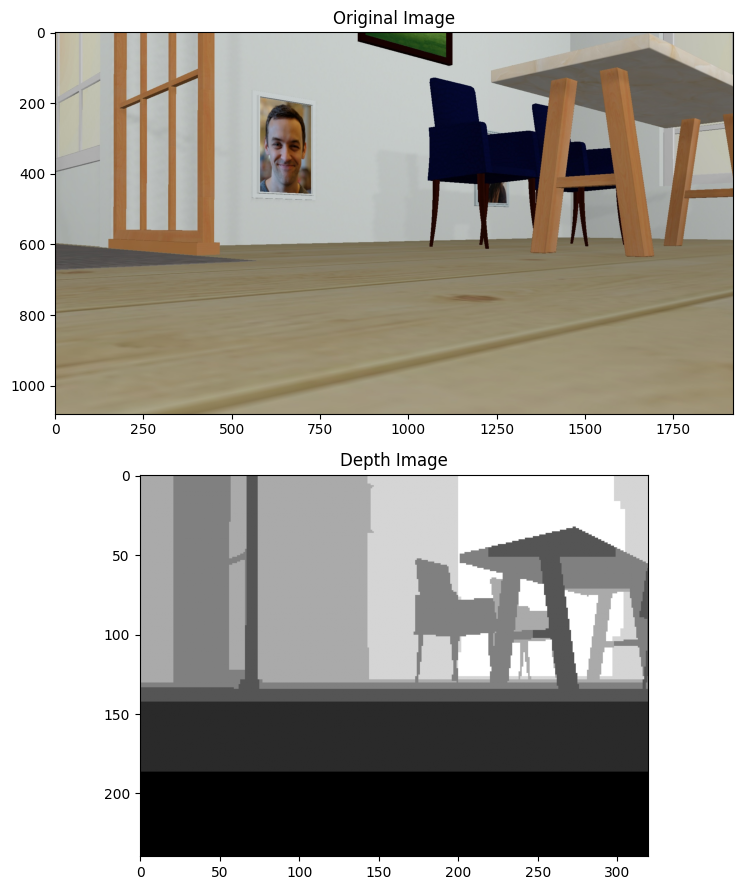

In [ ]:
# Create a figure and a set of subplots with 2 rows and 2 columns
import matplotlib.patches as patches
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))

# convert PIL→NumPy for plotting
img_np       = np.array(image)
depth_np     = np.array(depth_image)

axes[0].imshow(img_np)
axes[0].set_title('Original Image')

axes[1].imshow(depth_np, cmap = 'grey')
axes[1].set_title('Depth Image')

# Assuming "annotation_data" is your JSON data that contains the detections,
# and each detection has a dictionary "bbox" with the keys:
# "center_x", "center_y", "size_x", and "size_y".
print(image.size)
print(depth_image.size)
W, H = image.size
dw, dh = depth_image.size

# how much smaller is the depth?
scale_x = dw / W   # 320/1920 ≈ 0.1667
scale_y = dh / H   # 240/1080 ≈ 0.2222

print(scale_x)
print(scale_y)

# 1. load pretrained ResNet and chop off the final classification head
for detection in annotation_data["detections"]:
    bbox = detection["bbox"]
    # Extract bounding box parameters: center and size
    xc, yc, bw, bh = bbox["center_x"], bbox["center_y"], bbox["size_x"], bbox["size_y"]
    if xc is None or yc is None or bw is None or bh is None:
        continue

    # corner coords
    # Top left corner is (x1,y1)
    x1 = int(xc - bw/2)
    y1 = int(yc - bh/2)
    # Bottom right corner is (x2,y2)
    x2 = int(xc + bw/2)
    y2 = int(yc + bh/2)

    # clip to image bounds
    x1, x2 = max(0, x1), min(W, x2)
    y1, y2 = max(0, y1), min(H, y2)

    w_box = x2-x1
    h_box = y2-y1

    # scaled coords for depth image
    dx1 = int(x1 * scale_x)
    dy1 = int(y1 * scale_y)
    dx2 = int(x2 * scale_x)
    dy2 = int(y2 * scale_y)

    # clip just in case
    dx1, dx2 = max(0, dx1), min(dw, dx2)
    dy1, dy2 = max(0, dy1), min(dh, dy2)

    dw_box = dx2-dx1
    dh_box = dy2-dy1


    # Create a Rectangle patch
    rect_image = patches.Rectangle((x1, y1), w_box, h_box, linewidth=2,
                             edgecolor='r', facecolor='none')

    rect_depth = patches.Rectangle((dx1, dy1), dw_box, dh_box, linewidth=2,
                          edgecolor='r', facecolor='none')
    # Add the patch to the original image subplot
    axes[0].add_patch(rect_image)
    axes[1].add_patch(rect_depth)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the figure
plt.show()

Extracting each landmark individually and using the CLIP image encoder as a feature extractor, with dimension 512:

In [ ]:
updated_annotations_path = os.path.join('/content/drive/My Drive/CSCIProject/New Files', 'annotations_with_features_and_depth')
if not os.path.exists(updated_annotations_path):
    os.makedirs(updated_annotations_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

for json_filename in annotation_files:

    json_path = os.path.join(annotations_path, json_filename)
    with open(json_path, 'r') as f:
        annotation_data = json.load(f)

    # Get the base name from the JSON file (e.g., "image1" from "image1.json")
    base_name = os.path.splitext(json_filename)[0]

    # Find the corresponding image file (searching for any valid extension)
    image_file = None
    for ext in valid_extensions:
        candidate = base_name + ext
        candidate_path = os.path.join(imgs_path, candidate)
        if os.path.exists(candidate_path):
            image_file = candidate
            break
    if image_file is None:
        print(f"Image for {json_filename} not found. Skipping...")
        continue

    # Load the image and convert it to RGB (OpenCV loads as BGR by default)
    image_path = os.path.join(imgs_path, image_file)
    depth_image_path = os.path.join(depth_imgs_path, base_name + ".png")

    # 1) load your image (BGR)
    img = cv2.imread(image_path)
    # convert to RGB for plt
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    depth_img = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

    if depth_img is None:
        raise FileNotFoundError(f"Depth file not found: {depth_image_path}")
    # if for some reason it came in 3-channel, collapse it:
    if depth_img.ndim == 3:
        depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)

    H, W, _ = img_rgb.shape
    dh, dw = depth_img.shape

    # how much smaller is the depth?
    scale_x = dw / W   # 320/1920 ≈ 0.1667
    scale_y = dh / H   # 240/1080 ≈ 0.2222
    print(scale_x)
    print(scale_y)

    # For each detection in the JSON, compute mean inverse depth
    if "detections" in annotation_data:
        for i, detection in enumerate(annotation_data["detections"]):
            if "bbox" not in detection:
                continue
            bbox = detection["bbox"]
            # Extract bounding box parameters: center and size
            xc, yc, bw, bh = bbox["center_x"], bbox["center_y"], bbox["size_x"], bbox["size_y"]
            if xc is None or yc is None or bw is None or bh is None:
                continue

            # corner coords
            x1 = int(xc - bw/2)
            y1 = int(yc - bh/2)
            x2 = int(xc + bw/2)
            y2 = int(yc + bh/2)

            # clip to image bounds
            x1, x2 = max(0, x1), min(W, x2)
            y1, y2 = max(0, y1), min(H, y2)

            # scaled coords for depth image
            dx1 = int(x1 * scale_x)
            dy1 = int(y1 * scale_y)
            dx2 = int(x2 * scale_x)
            dy2 = int(y2 * scale_y)

            # clip just in case
            dx1, dx2 = max(0, dx1), min(dw, dx2)
            dy1, dy2 = max(0, dy1), min(dh, dy2)

            # crop (note: img[y1:y2, x1:x2])
            patch = img_rgb[y1:y2, x1:x2]
            depth_patch = depth_img[dy1:dy2, dx1:dx2]

            patch_pil = Image.fromarray(patch)      # <-- convert to PIL
            x = preprocess(patch_pil).unsqueeze(0).to(device)

            with torch.no_grad():
              image_features = model.encode_image(x)
              image_features = image_features.squeeze().cpu().numpy()

            # Append the computed value to the detection dictionary
            detection["feature_vector"] = image_features.tolist()
            detection["median_depth"] = float(np.median(depth_patch))
    else:
        print(f"No detections found in {json_filename}.")

    # Save the updated JSON file to the output folder
    updated_json_path = os.path.join(updated_annotations_path, json_filename)
    with open(updated_json_path, 'w') as f:
        json.dump(annotation_data, f, indent=2)

    print(f"Updated {json_filename} and saved to {updated_json_path}")

0.16666666666666666
0.2222222222222222
Updated 20250416_121036_621.json and saved to /content/drive/My Drive/CSCIProject/New Files/annotations_with_features_and_depth/20250416_121036_621.json
0.16666666666666666
0.2222222222222222
Updated 20250416_121055_103.json and saved to /content/drive/My Drive/CSCIProject/New Files/annotations_with_features_and_depth/20250416_121055_103.json
0.16666666666666666
0.2222222222222222
Updated 20250416_121046_570.json and saved to /content/drive/My Drive/CSCIProject/New Files/annotations_with_features_and_depth/20250416_121046_570.json
0.16666666666666666
0.2222222222222222
Updated 20250416_120934_309.json and saved to /content/drive/My Drive/CSCIProject/New Files/annotations_with_features_and_depth/20250416_120934_309.json
0.16666666666666666
0.2222222222222222
Updated 20250416_121024_999.json and saved to /content/drive/My Drive/CSCIProject/New Files/annotations_with_features_and_depth/20250416_121024_999.json
0.16666666666666666
0.2222222222222222
U